In [19]:
from definitions import *
from trainTestValSplit import getTrainTestValSplit
from preProcessing import preProcess

from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
train_concat, test_concat, val_concat = getTrainTestValSplit(
    _dataset_path=f'{ROOT_DIR}/dataset/ExtraSensory/Processed'
)

In [3]:
train_x, train_y = preProcess(train_concat)
test_x, test_y = preProcess(test_concat)
val_x, val_y = preProcess(val_concat)

columns = train_x.columns
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)
val_x = val_x.fillna(0)

n_columns = len(columns)
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
test_x = test_x.to_numpy()
test_y = test_y.to_numpy()
val_x = val_x.to_numpy()
val_y = val_y.to_numpy()

In [4]:
n_features: int = n_columns

In [5]:
train_y = encodeTarget(train_y)
test_y = encodeTarget(test_y)
val_y = encodeTarget(val_y)

In [6]:
train_x = reshape_and_truncate(train_x, (-1, window_size, n_features))
train_y = reshape_and_truncate(train_y, (-1, window_size, len(main_activity_label_classes)))

test_x = reshape_and_truncate(test_x, (-1, window_size, n_features))
test_y = reshape_and_truncate(test_y, (-1, window_size, len(main_activity_label_classes)))

val_x = reshape_and_truncate(val_x, (-1, window_size, n_features))
val_y = reshape_and_truncate(val_y, (-1, window_size, len(main_activity_label_classes)))

In [7]:
with tf.device('/cpu:0'):
    model = tf.keras.Sequential()

    layer = tf.keras.layers.Normalization(axis=-1)
    layer.adapt(train_x)
    model.add(layer)
    model.add(tf.keras.layers.LSTM(100, return_sequences=True, activation='tanh'))
    model.add(tf.keras.layers.LSTM(50, return_sequences=True, activation='tanh'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(n_y, activation=tf.keras.activations.softmax))

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=
    tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
    ), metrics=['acc'])
    history = model.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), epochs=epochs, batch_size=batch_size,
                        callbacks=[
                            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience,
                                                             mode='auto', restore_best_weights=True)])
    predict = model.predict(test_x)

Epoch 1/100
668/668 [==============================] - 10s 11ms/step - loss: 1.4927 - acc: 0.5116 - val_loss: 1.2373 - val_acc: 0.6005
Epoch 2/100
668/668 [==============================] - 9s 13ms/step - loss: 1.0389 - acc: 0.6884 - val_loss: 0.9613 - val_acc: 0.6974
Epoch 3/100
668/668 [==============================] - 9s 13ms/step - loss: 0.8801 - acc: 0.7359 - val_loss: 0.8773 - val_acc: 0.7187
Epoch 4/100
668/668 [==============================] - 9s 13ms/step - loss: 0.8090 - acc: 0.7541 - val_loss: 0.8298 - val_acc: 0.7323
Epoch 5/100
668/668 [==============================] - 9s 13ms/step - loss: 0.7574 - acc: 0.7668 - val_loss: 0.7997 - val_acc: 0.7395
Epoch 6/100
668/668 [==============================] - 9s 13ms/step - loss: 0.7167 - acc: 0.7769 - val_loss: 0.7774 - val_acc: 0.7454
Epoch 7/100
668/668 [==============================] - 9s 13ms/step - loss: 0.6806 - acc: 0.7875 - val_loss: 0.7618 - val_acc: 0.7498
Epoch 8/100
668/668 [==============================] - 9s 13m

In [8]:
gold_labels = get_labels(test_y)
predicted_labels = get_labels(predict)

In [21]:
print(f'F1: {f1_score(gold_labels, predicted_labels, average="weighted")}')
print(f'Precision: {precision_score(gold_labels, predicted_labels, average="weighted", zero_division=0)}')
print(f'Recall: {recall_score(gold_labels, predicted_labels, average="weighted", zero_division=0)}')

F1: 0.7798538736076895
Precision: 0.7812062687932602
Recall: 0.7850049652432969


In [10]:
tf.math.confusion_matrix(gold_labels, predicted_labels)

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[ 690,    3,   28,    5,    4,    0,    1],
       [   6, 1444,  235,   16,    0,    0,    0],
       [  22,   81, 2072,  203,   28,    0,    4],
       [  16,   29,  303,  263,   55,    0,    4],
       [   2,    1,  101,   55,  171,    0,   11],
       [   2,    0,    0,    0,   13,    0,    0],
       [   4,    1,   32,   11,   23,    0,  103]])>

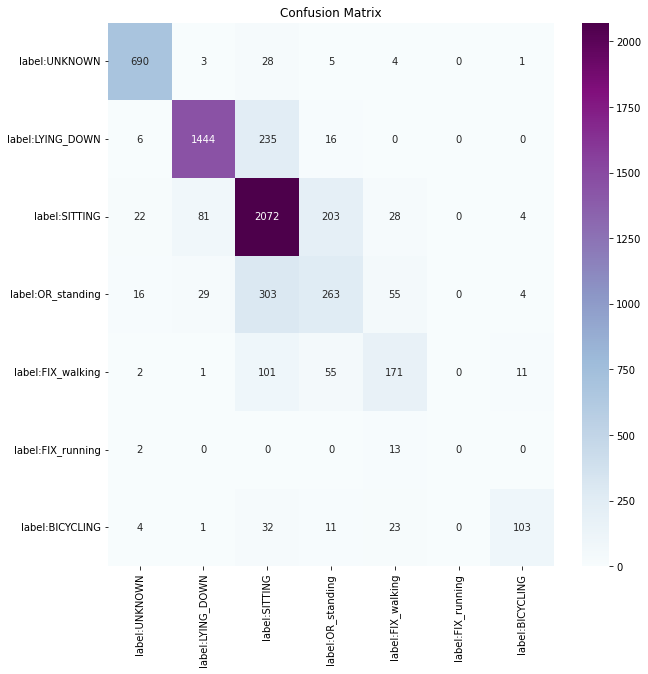

In [11]:
plot_conf_matrix(gold_labels, predicted_labels)

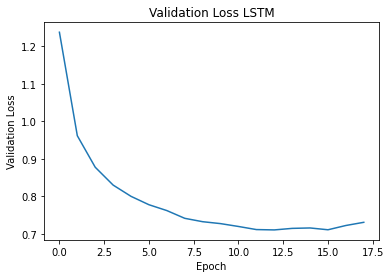

In [12]:
plot_val_loss_progress(history)